In [1]:
import sys
from datetime import datetime, date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Machine Learning
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Optimization
import gurobipy as gp
from gurobipy import GRB

# Local Imports
%reload_ext autoreload
%autoreload 2
from regression_controller_utils import (training_data_generation, calculate_peak_demand_charge, calculate_total_bill,
                                         real_time_control, add_arbitrage)

## Data Import and Cleaning

In [2]:
#----------------------------
# Load data
#----------------------------
# Demand data
df_demand = pd.read_csv("demand_data.csv", parse_dates=['time'])
df_demand = df_demand[['time', 'demand_MW']].rename(columns={'demand_MW': 'demand'})
df_demand.set_index('time', inplace=True)

# Temperature data
df_temp = pd.read_csv("temp_data.csv", parse_dates=['time'])
df_temp = df_temp[['time', 'temperature']]
df_temp.set_index('time', inplace=True)

# Merge demand + temperature
df = df_demand.join(df_temp, how='outer').sort_index()

#----------------------------
# Clean missing data
#----------------------------
# Fill missing temperature (forward then backward)
if df['temperature'].isnull().any():
    df['temperature'] = df['temperature'].ffill().bfill()

# Fill missing demand if needed
if df['demand'].isnull().any():
    df['demand'] = df['demand'].ffill().bfill()

#----------------------------
# Time parameters
#----------------------------
# Compute Ts dynamically from data
delta = df.index.to_series().diff().dropna()
median_delta = delta.median()
Ts = median_delta.total_seconds() / 3600      # timestep in hours
steps_per_hour = int(round(1 / Ts))
steps_per_day = 24 * steps_per_hour

print(f"Detected timestep Ts = {Ts:.5f} hours ({Ts*60:.2f} minutes)")

# Year for test/forecast
year_to_predict = 2024
mins_in_peak = 30 # Duration of peak demand calculation (min)

#----------------------------
# Train/test split
#----------------------------
train_df = df[df.index.year < year_to_predict].copy()
test_df  = df[df.index.year == year_to_predict].copy()

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Data timeframe: {df.index.year.min()} - {df.index.year.max()}")

Detected timestep Ts = 0.08333 hours (5.00 minutes)
Training data shape: (525888, 2)
Test data shape: (105408, 2)
Data timeframe: 2019 - 2024


## Battery and Arbitrage Setup

In [3]:
#----------------------------
# Battery Parameters
#----------------------------
P_batt = 0.6                  # Battery power rating (MW)
E_batt = 2.2 * P_batt         # Battery energy capacity (MWh)
E_min  = 0.2 * E_batt         # Minimum SoC (MWh)
e0     = 0.5 * E_batt         # Initial SoC (MWh)
eta    = 0.9                  # Round-trip efficiency

#----------------------------
# Arbitrage/Price Data
#----------------------------

# Load arbitrage charge/discharge schedule and real-time price data
dispatch_df = pd.read_csv("arbitrage_data_c0.csv", parse_dates=["Time Stamp"])

# Ensure datetime index and sort
dispatch_df['Time Stamp'] = pd.to_datetime(dispatch_df['Time Stamp'])
dispatch_df = dispatch_df.set_index('Time Stamp').sort_index()

# Remove normalization
q_arb = dispatch_df["Charge_norm"].values * (E_batt / Ts/ eta)
d_arb = dispatch_df["Discharge_norm"].values * (E_batt / Ts*eta)

# Extract real-time prices
prices = dispatch_df["Real_Time_Price_$_per_MWh"].copy() # $/MWh

# Fixed charge per month
monthly_charge = 71

# Assign monthly peak price
# Summer months (June–September) have higher peak price
dispatch_df['peak_price'] = np.where( dispatch_df.index.month.isin([6, 7, 8, 9]),
    42.80 * 1000,   # Summer peak charge ($/MW)
    33.50 * 1000)    # Non-summer peak charge ($/MW)

## Demand Forecasting

Forecasting days: 100%|█████████████████████████████████████| 366/366 [02:05<00:00,  2.91it/s]


RMSE: 0.06, MAE: 0.03, MAPE: 7.75%


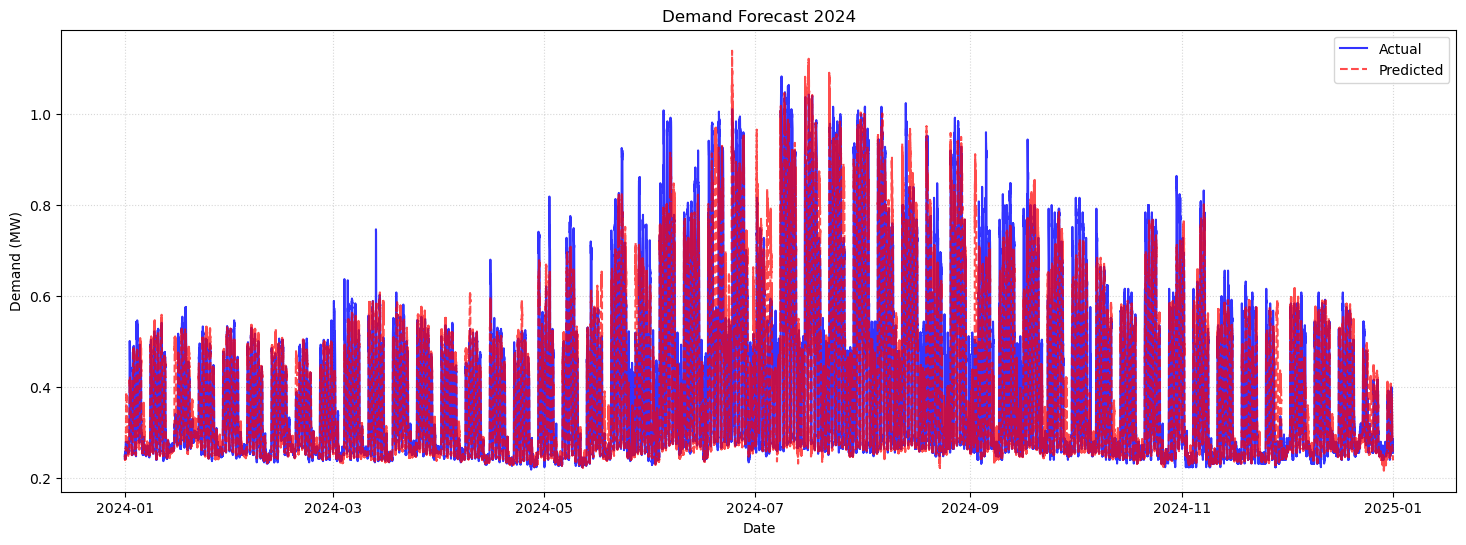

In [6]:
'''
- Day-ahead, recursive electricity demand forecasting with integrated peak shaving
- Time-based, cyclical, lagged, and polynomial features train an XGBoost model
- Daily forecasts feed previous predictions as lags
- Predicted demand drives Gurobi-based SoC optimization and real-time battery control
'''

#----------------------------
# Feature Engineering
#----------------------------

# Time-based features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['dayofyear'] = df.index.dayofyear
df['is_weekend'] = (df['dayofweek']>=5).astype(int)

# Cyclical transformations to capture periodicity
df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)
df['dayofweek_sin'] = np.sin(2*np.pi*df['dayofweek']/7)
df['dayofweek_cos'] = np.cos(2*np.pi*df['dayofweek']/7)
df['month_sin'] = np.sin(2*np.pi*df['month']/12)
df['month_cos'] = np.cos(2*np.pi*df['month']/12)
df['dayofyear_sin'] = np.sin(2*np.pi*df['dayofyear']/365.25)
df['dayofyear_cos'] = np.cos(2*np.pi*df['dayofyear']/365.25)

# Demand lags - intra-day and daily
for i in range(1,8):
    df[f'demand_lag_{i}_day'] = df['demand'].shift(i*steps_per_day)
for h in [1,2,3,6,12]:
    df[f'demand_lag_{h}_hour_intra_day'] = df['demand'].shift(h*steps_per_hour)

# Temperature lags
for lag_h in [1,2,3,6,12,24,48,72,168]:
    df[f'temp_lag_{lag_h}h'] = df['temperature'].shift(lag_h*steps_per_hour)

# Rolling temperature statistics
df['temp_roll_mean_3h'] = df['temperature'].shift(1).rolling(3*steps_per_hour,min_periods=1).mean()
df['temp_roll_std_3h'] = df['temperature'].shift(1).rolling(3*steps_per_hour,min_periods=1).std()
df['temp_roll_mean_24h'] = df['temperature'].shift(1).rolling(24*steps_per_hour,min_periods=1).mean()
df['temp_roll_std_24h'] = df['temperature'].shift(1).rolling(24*steps_per_hour,min_periods=1).std()

# Polynomial & interaction features
df['temperature_squared'] = df['temperature']**2
df['temperature_cubed'] = df['temperature']**3
df['temp_hour_interaction'] = df['temperature']*df['hour']

# Drop rows with missing lag values
df.dropna(inplace=True) 


#----------------------------
# Train base XGBoost Model
#----------------------------

train_df = df[df.index.year < year_to_predict].copy()
features = [c for c in train_df.columns if c != 'demand']

X_train = train_df[features].astype(np.float32)
y_train = train_df['demand'].astype(np.float32)

dtrain = xgb.DMatrix(X_train, label=y_train)

params = {'objective':'reg:squarederror','eta':0.05,'max_depth':6,'subsample':0.8,
          'colsample_bytree':0.8,'seed':42,'tree_method':'hist','eval_metric':'rmse'}

base_model = xgb.train(params,dtrain,num_boost_round=1000)

#----------------------------
# Recursive Forecast for Target Year
#----------------------------
dates_target = df[df.index.year==year_to_predict].index.normalize().unique()

all_results = []
SoC_previous = e0 
p_previous = 0 
current_month = None

for date in tqdm(dates_target, desc="Forecasting days"):
    # Create daily index
    day_index = pd.date_range(date, periods=steps_per_day, freq='5min')
    day_month = day_index[0].month
    X_day = pd.DataFrame(index=day_index)

    prices_day = dispatch_df.reindex(day_index)['Real_Time_Price_$_per_MWh'].values
    pk_price_day = dispatch_df.reindex(day_index)['peak_price'].iloc[0]

    # reset monthly peak if new month starts
    if current_month != day_month:
        p_previous = 0
        current_month = day_month
    
    # Static features
    X_day['hour'] = X_day.index.hour
    X_day['dayofweek'] = X_day.index.dayofweek
    X_day['month'] = X_day.index.month
    X_day['dayofyear'] = X_day.index.dayofyear
    X_day['is_weekend'] = (X_day['dayofweek']>=5).astype(int)
    
    # Cyclical transformations
    X_day['hour_sin'] = np.sin(2*np.pi*X_day['hour']/24)
    X_day['hour_cos'] = np.cos(2*np.pi*X_day['hour']/24)
    X_day['dayofweek_sin'] = np.sin(2*np.pi*X_day['dayofweek']/7)
    X_day['dayofweek_cos'] = np.cos(2*np.pi*X_day['dayofweek']/7)
    X_day['month_sin'] = np.sin(2*np.pi*X_day['month']/12)
    X_day['month_cos'] = np.cos(2*np.pi*X_day['month']/12)
    X_day['dayofyear_sin'] = np.sin(2*np.pi*X_day['dayofyear']/365.25)
    X_day['dayofyear_cos'] = np.cos(2*np.pi*X_day['dayofyear']/365.25)
    
    # Temperature features
    X_day['temperature'] = df.reindex(day_index)['temperature'].ffill().values
    
    for lag_h in [1,2,3,6,12,24,48,72,168]:
        lag_idx = day_index - pd.Timedelta(hours=lag_h)
        X_day[f'temp_lag_{lag_h}h'] = df.reindex(lag_idx)['temperature'].ffill().values
    
    # Rolling statistics
    temp_past = pd.concat([df.loc[:day_index[0]-pd.Timedelta(minutes=5),'temperature'], X_day['temperature']])
    X_day['temp_roll_mean_3h'] = temp_past.shift(1).rolling(3*steps_per_hour,min_periods=1).mean().loc[day_index].values
    X_day['temp_roll_std_3h'] = temp_past.shift(1).rolling(3*steps_per_hour,min_periods=1).std().loc[day_index].values
    X_day['temp_roll_mean_24h'] = temp_past.shift(1).rolling(24*steps_per_hour,min_periods=1).mean().loc[day_index].values
    X_day['temp_roll_std_24h'] = temp_past.shift(1).rolling(24*steps_per_hour,min_periods=1).std().loc[day_index].values
    
    # Polynomial & interaction
    X_day['temperature_squared'] = X_day['temperature']**2
    X_day['temperature_cubed'] = X_day['temperature']**3
    X_day['temp_hour_interaction'] = X_day['temperature']*X_day['hour']
    
    # Initialize demand lags
    for h in [1,2,3,6,12]:
        X_day[f'demand_lag_{h}_hour_intra_day'] = 0.0
    for d in range(1,8):
        X_day[f'demand_lag_{d}_day'] = 0.0
    
    X_day_np = X_day[features].values.astype(np.float32)
    day_preds = np.zeros(len(day_index), dtype=np.float32)
    
    # Recursive forecast
    for t in range(len(day_index)):
        # intra-day lags
        for h in [1,2,3,6,12]:
            lag_idx = t - h*steps_per_hour
            if lag_idx >= 0:
                X_day_np[t, features.index(f'demand_lag_{h}_hour_intra_day')] = day_preds[lag_idx]
            else:
                hist_idx = day_index[t] - pd.Timedelta(hours=h)
                if hist_idx in df.index:
                    X_day_np[t, features.index(f'demand_lag_{h}_hour_intra_day')] = df.loc[hist_idx,'demand']
        
        # daily lags
        for d in range(1,8):
            lag_idx_day = day_index[t] - pd.Timedelta(days=d)
            if lag_idx_day in df.index:
                X_day_np[t, features.index(f'demand_lag_{d}_day')] = df.loc[lag_idx_day,'demand']
        # Predict demand at timestep t
        X_day_row = pd.DataFrame(X_day_np[t].reshape(1, -1), columns=features)
        dmatrix_t = xgb.DMatrix(X_day_row)
        day_preds[t] = base_model.predict(dmatrix_t)[0]

    #----------------------------
    # Optimization using demand forecast
    #----------------------------
    _, _, SoC_pred, d_pred, q_pred, p_pred = training_data_generation(E_batt=E_batt, P_batt=P_batt, E_min=E_min,
        e0=max(SoC_previous, E_min), eta=eta, D=day_preds, Ts=Ts, mins_in_peak=mins_in_peak, delta=1e-6)

    p_daily = max(p_previous, p_pred)
    actual_demand = df.loc[day_index,'demand'].values

    #----------------------------
    # Real-time control
    #----------------------------
    net_demand_PS, q_PS, d_PS, SoC_PS, p_current = real_time_control(D=actual_demand, SoC_reserve=SoC_pred, Ts=Ts,
        eta=eta, p_init=p_daily, p_t_series = np.zeros(len(actual_demand)), P_batt=P_batt, E_batt=E_batt, e0=SoC_previous)

    # Update values for next day
    SoC_previous = SoC_PS[-1]
    p_previous = p_current

    # Store daily results
    df_day = pd.DataFrame({
        'time': day_index,
        'predicted_demand': day_preds,
        'predicted_SoC': SoC_pred,
        'actual_demand': actual_demand,
        'SoC_PS': SoC_PS,
        'charge_PS': q_PS,
        'discharge_PS': d_PS,
        'net_demand': net_demand_PS
    })
    df_day['p_used'] = p_current
    
    all_results.append(df_day)
    
#----------------------------
# Concatenate and Evaluate Forecast
#----------------------------
results_target = pd.concat(all_results).reset_index(drop=True)
y_true = results_target['actual_demand']
y_pred = results_target['predicted_demand']

rmse = np.sqrt(mean_squared_error(y_true,y_pred))
mae = mean_absolute_error(y_true,y_pred)
mape = np.mean(np.abs((y_true-y_pred)/y_true.replace(0,np.nan)))*100

print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")

# Plot actual vs predicted demand 
plt.figure(figsize=(18,6)) 
plt.plot(results_target['time'], y_true, label='Actual', color='blue', alpha=0.8) 
plt.plot(results_target['time'], y_pred, label='Predicted', color='red', linestyle='--', alpha=0.7) 
plt.title(f'Demand Forecast {year_to_predict}') 
plt.xlabel('Date') 
plt.ylabel('Demand (MW)')
plt.legend() 
plt.grid(True, linestyle=':', alpha=0.5) 
plt.show()

## Plot Results - Peak Shaving

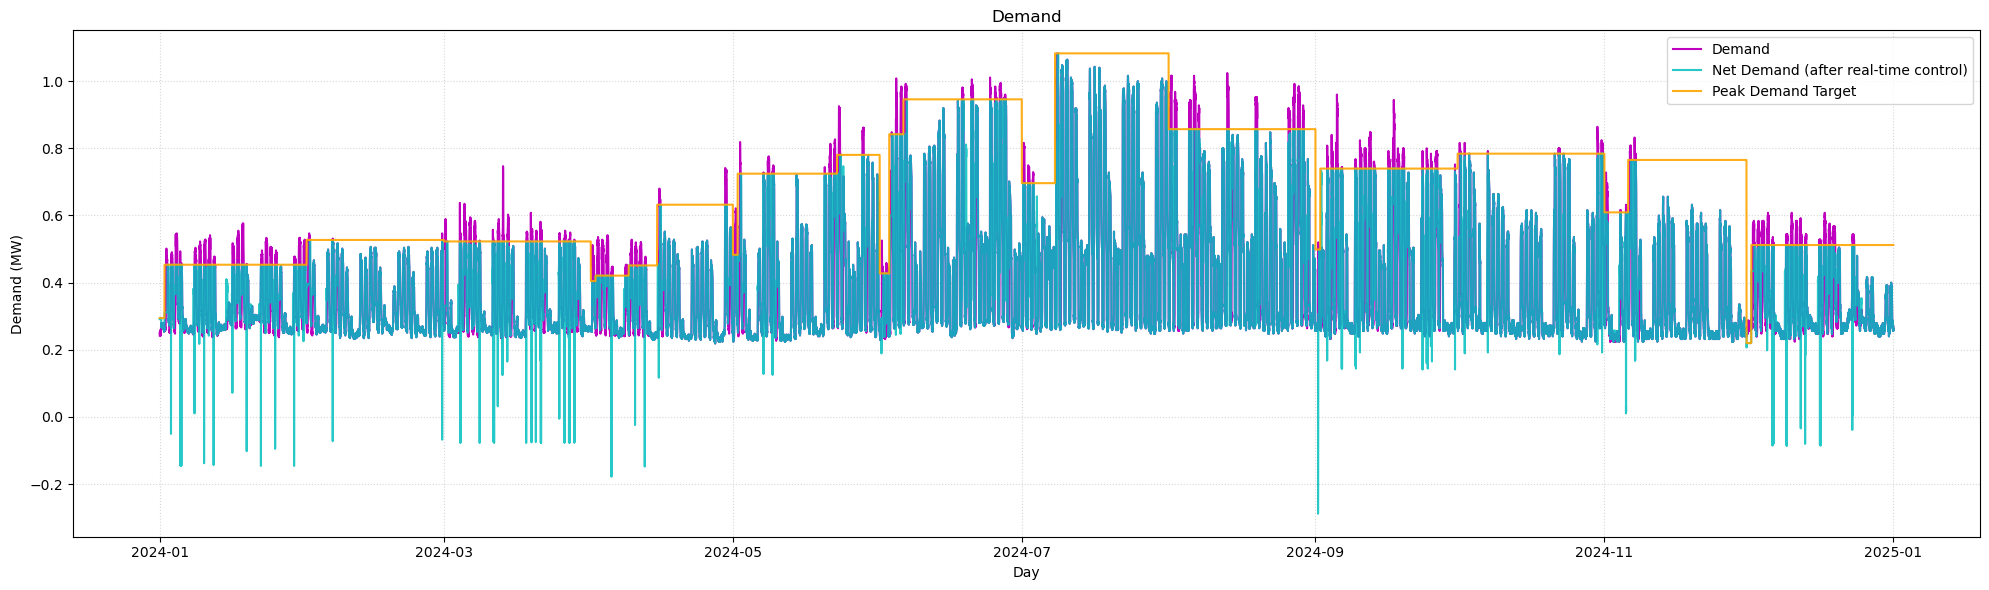

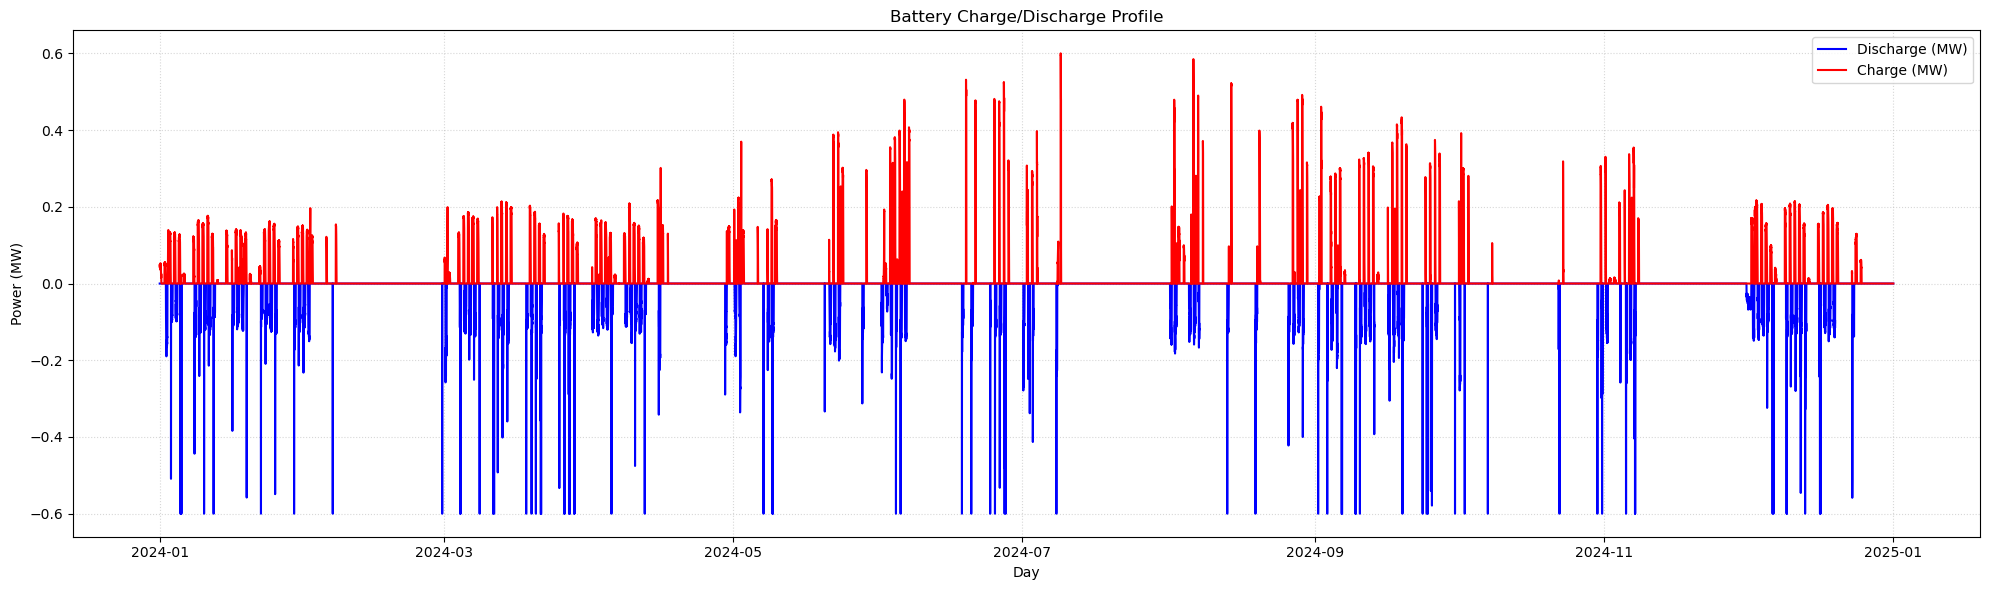

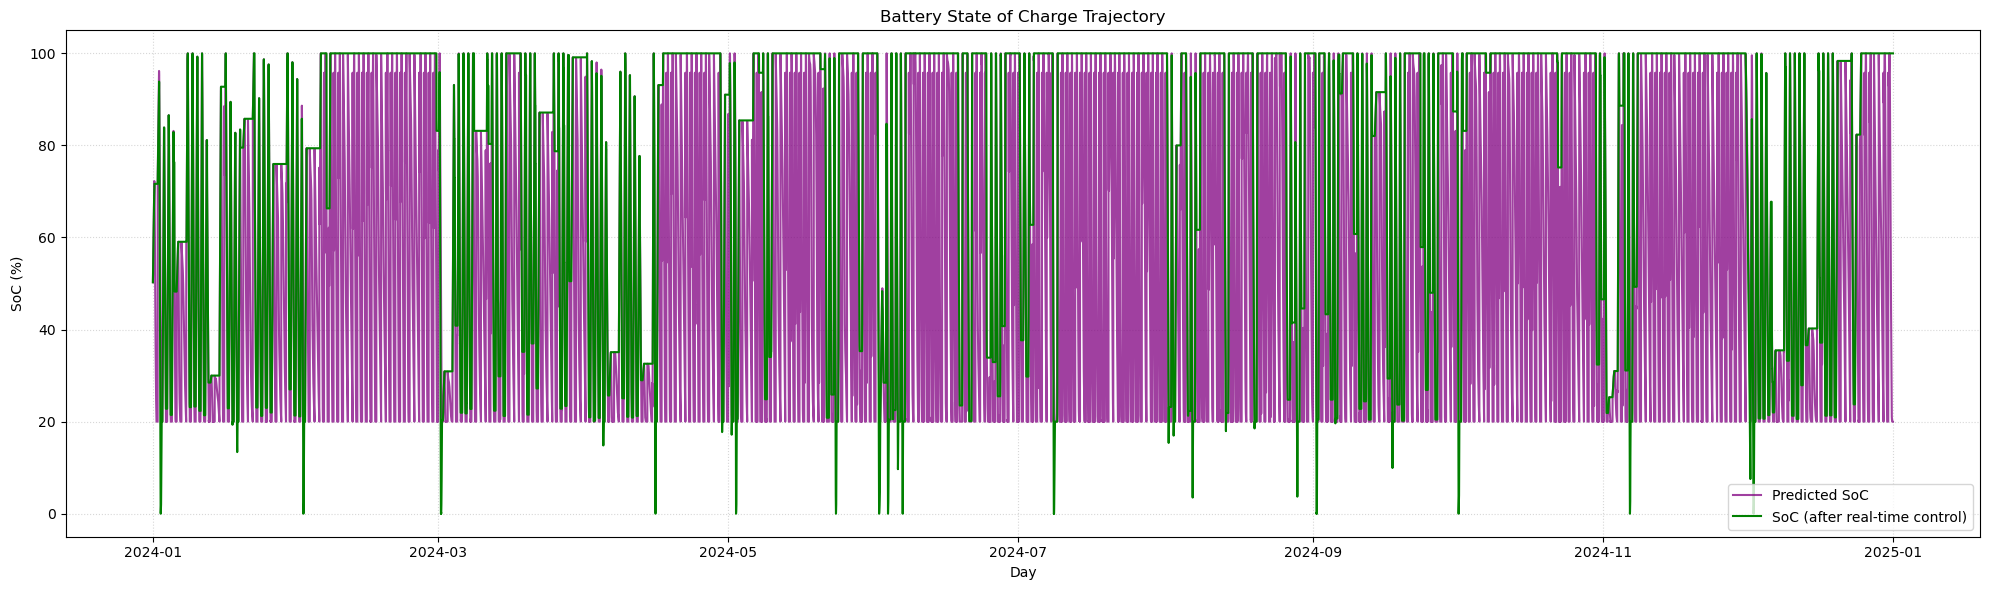

In [7]:
# Define time range for plotting (days)
idx1 = 0
idx2 = int(24 / Ts) * 366 

# -------------------------------
# 1. Demand vs Controller / Kernel Predictions
# -------------------------------

plt.figure(figsize=(20, 6))
plt.clf()

# Plot original demand
plt.plot(results_target['time'][idx1:idx2], y_true[idx1:idx2], label='Demand', color='m', linewidth=1.5)

# Plot net demand after real-time control
plt.plot(results_target['time'][idx1:idx2], results_target['net_demand'][idx1:idx2], label='Net Demand (after real-time control)', color='c', alpha=0.85, linewidth=1.5)

# Plot real-time controller peak shaving target
plt.plot(results_target['time'][idx1:idx2], results_target['p_used'][idx1:idx2], label='Peak Demand Target', color='orange', alpha=0.9, linewidth=1.5)


# Labels, grid, legend, title
plt.xlabel('Day')
plt.ylabel('Demand (MW)')
plt.title('Demand')
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# 2. Battery Charge / Discharge Power
# -------------------------------

plt.figure(figsize=(20, 6))
plt.clf()

# Plot discharge and charge
plt.plot(results_target['time'][idx1:idx2], -results_target['discharge_PS'][idx1:idx2], label='Discharge (MW)', color='blue', linewidth=1.5)
plt.plot(results_target['time'][idx1:idx2], results_target['charge_PS'][idx1:idx2], label='Charge (MW)', color='red', linewidth=1.5)

plt.xlabel('Day')
plt.ylabel('Power (MW)')
plt.title('Battery Charge/Discharge Profile')
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# 3. SoC Trajectory
# -------------------------------
plt.figure(figsize=(20, 6))
plt.clf()

# Plot Kernel Regression SoC
plt.plot(results_target['time'][idx1:idx2], (results_target['predicted_SoC'][idx1:idx2] / E_batt) * 100, label='Predicted SoC', color='purple', linewidth=1.5, alpha=0.75)
# Plot Real-Time Controller SoC
plt.plot(results_target['time'][idx1:idx2], (results_target['SoC_PS'][idx1:idx2] / E_batt) * 100, label='SoC (after real-time control)', color='green', linewidth=1.5)


plt.xlabel('Day')
plt.ylabel('SoC (%)')
plt.title('Battery State of Charge Trajectory')
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Add Arbitrage

In [8]:
SoC_PSA, net_demand_PSA, q_PSA, d_PSA = add_arbitrage(results_target['actual_demand'].values, results_target['charge_PS'].values, results_target['discharge_PS'].values, results_target['SoC_PS'].values,
                                                            P_batt, E_batt, Ts, results_target['p_used'], eta, q_arb, d_arb, e0)

## Plot Results - Peak Shaving and Arbitrage

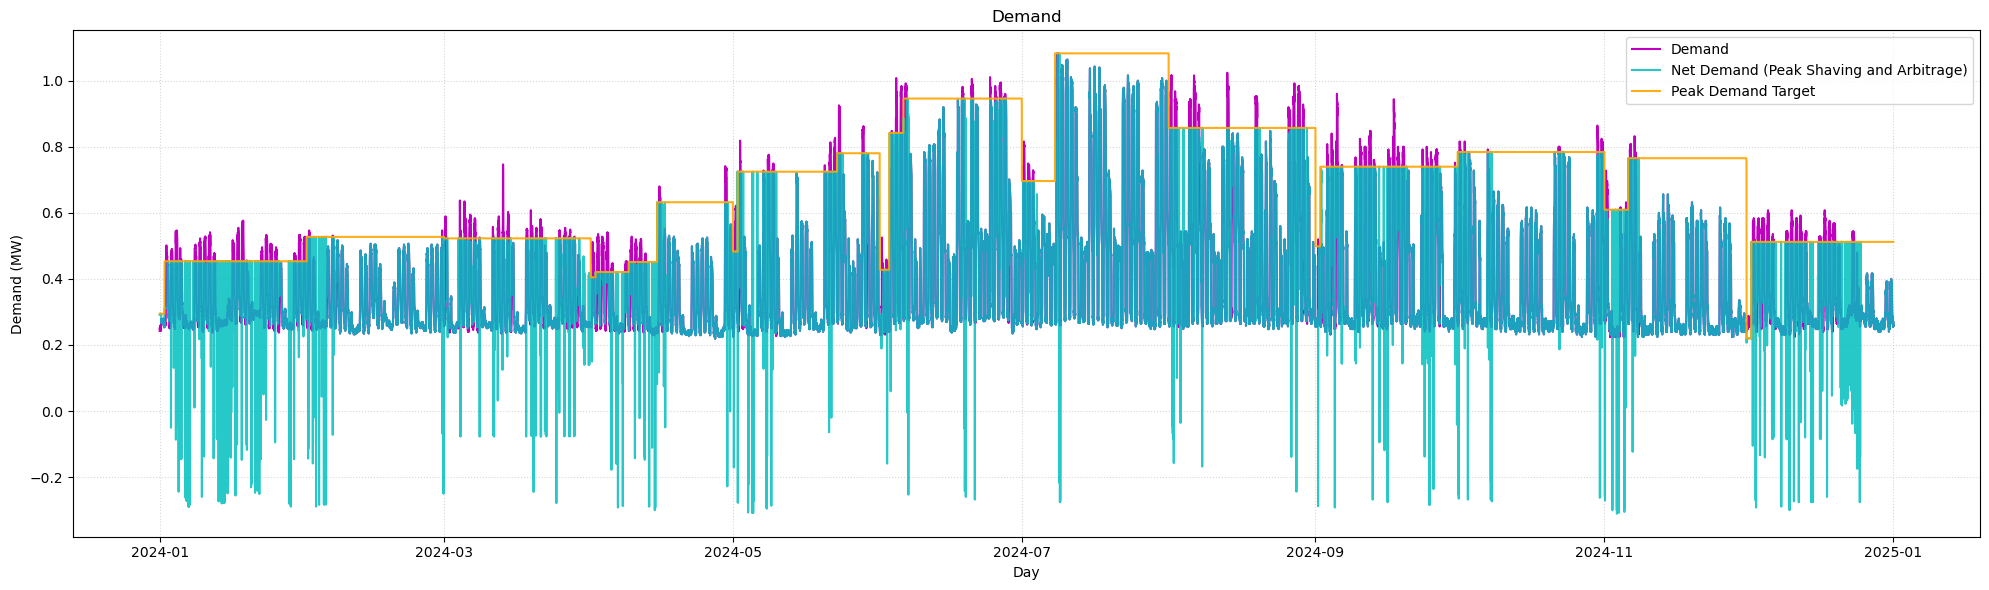

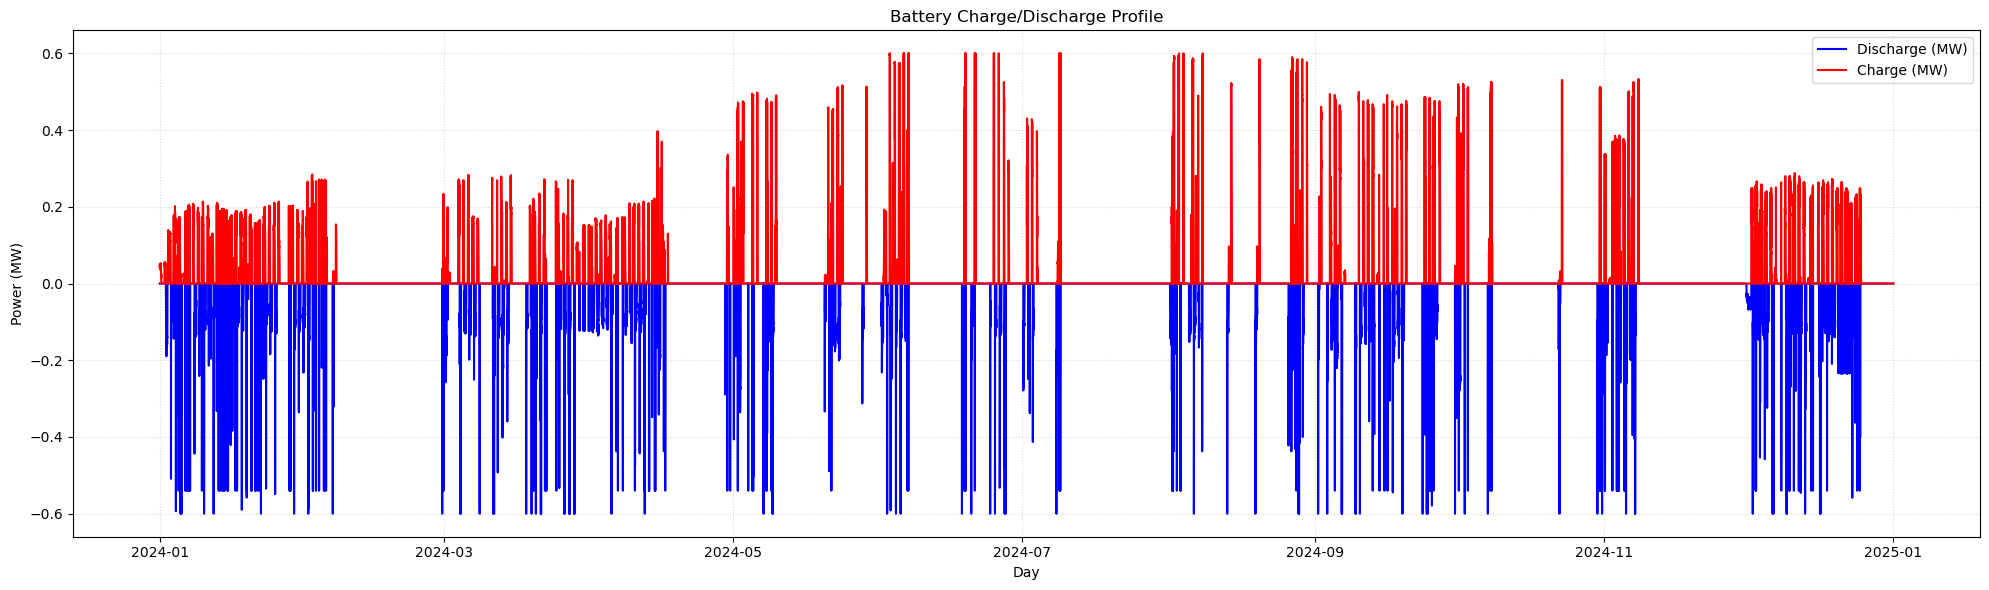

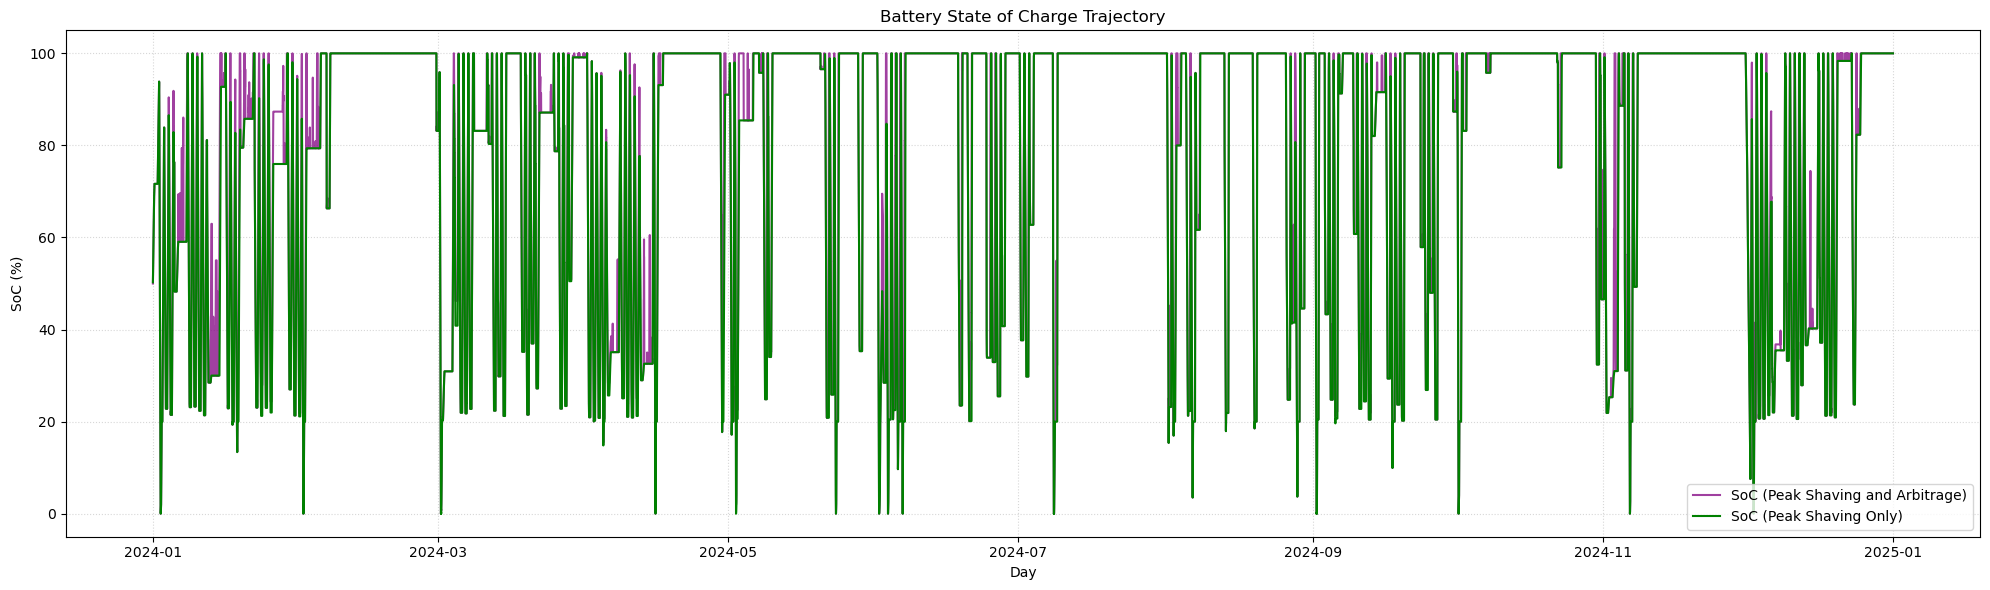

In [9]:
# Define time range for plotting (days)
idx1 = 0
idx2 = int(24 / Ts) * 366 

# -------------------------------
# 1. Demand vs Controller / Kernel Predictions
# -------------------------------

plt.figure(figsize=(20, 6))
plt.clf()

# Plot original demand
plt.plot(results_target['time'][idx1:idx2], y_true[idx1:idx2], label='Demand', color='m', linewidth=1.5)

# Plot net demand after peak shaving and arbitrage
plt.plot(results_target['time'][idx1:idx2], net_demand_PSA[idx1:idx2], label='Net Demand (Peak Shaving and Arbitrage)', color='c', alpha=0.85, linewidth=1.5)

# Plot real-time controller peak shaving target
plt.plot(results_target['time'][idx1:idx2], results_target['p_used'][idx1:idx2], label='Peak Demand Target', color='orange', alpha=0.9, linewidth=1.5)


# Labels, grid, legend, title
plt.xlabel('Day')
plt.ylabel('Demand (MW)')
plt.title('Demand')
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# 2. Battery Charge / Discharge Power
# -------------------------------

plt.figure(figsize=(20, 6))
plt.clf()

# Plot discharge and charge
plt.plot(results_target['time'][idx1:idx2], -d_PSA[idx1:idx2], label='Discharge (MW)', color='blue', linewidth=1.5)
plt.plot(results_target['time'][idx1:idx2], q_PSA[idx1:idx2], label='Charge (MW)', color='red', linewidth=1.5)

plt.xlabel('Day')
plt.ylabel('Power (MW)')
plt.title('Battery Charge/Discharge Profile')
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# 3. SoC Trajectory
# -------------------------------
plt.figure(figsize=(20, 6))
plt.clf()

# Plot Kernel Regression SoC
plt.plot(results_target['time'][idx1:idx2], (SoC_PSA[idx1:idx2] / E_batt) * 100, label='SoC (Peak Shaving and Arbitrage)', color='purple', linewidth=1.5, alpha=0.75)
# Plot Real-Time Controller SoC
plt.plot(results_target['time'][idx1:idx2], (results_target['SoC_PS'][idx1:idx2] / E_batt) * 100, label='SoC (Peak Shaving Only)', color='green', linewidth=1.5)


plt.xlabel('Day')
plt.ylabel('SoC (%)')
plt.title('Battery State of Charge Trajectory')
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Bill Calculation

In [10]:
print('No Storage')
bill_no_storage = calculate_total_bill(
    demand_profile=results_target['actual_demand'].values, timestamps=results_target['time'].values, Ts=Ts, 
                                         mins_in_peak=mins_in_peak, monthly_charge=monthly_charge, RTP=prices, std_pricing = True, verbose=True)
print('Peak Shaving Only')
bill_PS = calculate_total_bill(
    demand_profile=results_target['net_demand'].values, timestamps=results_target['time'].values, Ts=Ts, 
                                         mins_in_peak=mins_in_peak, monthly_charge=monthly_charge, RTP=prices,std_pricing = True, verbose=True)
print('PS + Arb')
bill_PSA = calculate_total_bill(
    demand_profile=net_demand_PSA, timestamps=results_target['time'].values, Ts=Ts, 
                                         mins_in_peak=mins_in_peak, monthly_charge=monthly_charge, RTP=prices,std_pricing = True, verbose=True)


# Calculate the savinga
savings_PSA = bill_no_storage - bill_PSA
savings_PS = bill_no_storage - bill_PS

# Print the results
print("--- Bill Comparison ---")
print(f"Total Bill (without storage): ${bill_no_storage:,.2f}")
print(f"Total Bill (PS and arbitrage):    ${bill_PSA:,.2f}")
print("-" * 30)
print(f"Total Savings (with PS + Arbitrage):  ${savings_PSA:,.2f}")
print(f"Total Savings (with PS Only):  ${savings_PS:,.2f}")


print('\nCycle Number Peak Shaving and Arbitrage:')
opt_cycles_PSA = (np.sum(abs(d_PSA/eta-q_PSA*eta))/2*Ts )/ E_batt
print(f'{opt_cycles_PSA:.2f}')

No Storage
--- Peak Demand Price Breakdown ---
Month 01 | all_hours    | Peak 0.5760 MW @ 2024-01-18 15:10 | Rate $33.50/kW | Cost $19,296.00
Month 02 | all_hours    | Peak 0.5456 MW @ 2024-02-01 13:20 | Rate $33.50/kW | Cost $18,278.59
Month 03 | all_hours    | Peak 0.7396 MW @ 2024-03-13 12:15 | Rate $33.50/kW | Cost $24,775.11
Month 04 | all_hours    | Peak 0.7353 MW @ 2024-04-29 15:20 | Rate $33.50/kW | Cost $24,631.19
Month 05 | all_hours    | Peak 0.9204 MW @ 2024-05-23 10:00 | Rate $33.50/kW | Cost $30,834.89
Month 06 | all_hours    | Peak 0.9996 MW @ 2024-06-20 11:15 | Rate $42.80/kW | Cost $42,780.98
Month 07 | all_hours    | Peak 1.0813 MW @ 2024-07-08 12:55 | Rate $42.80/kW | Cost $46,281.07
Month 08 | all_hours    | Peak 1.0120 MW @ 2024-08-01 14:10 | Rate $42.80/kW | Cost $43,313.60
Month 09 | all_hours    | Peak 0.9493 MW @ 2024-09-05 13:10 | Rate $42.80/kW | Cost $40,631.47
Month 10 | all_hours    | Peak 0.8533 MW @ 2024-10-30 12:50 | Rate $33.50/kW | Cost $28,586.67
Mon